In [27]:
import random
from os import path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV # <--- Added GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [28]:
SEED = 491
random.seed(SEED)
np.random.seed(SEED)

In [29]:
data_path = "../../data/previous"
syn_seer = path.join(data_path, "synthetic_patients_2.0_seer.csv")
processed_cohort = path.join(data_path, "processed_cohort_with_age.csv")
syn_seer_dataset = pl.read_csv(syn_seer)
cohort_dataset = pl.read_csv(processed_cohort)

In [30]:
label_col = "target"

X_seer = syn_seer_dataset.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
y_seer = syn_seer_dataset.get_column(label_col).to_numpy().astype(np.int64).ravel()
X_train, X_val, y_train, y_val = train_test_split(X_seer, y_seer, test_size=0.2, stratify=y_seer, random_state=491)

X_test = cohort_dataset.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
y_test = cohort_dataset.get_column(label_col).to_numpy().astype(np.int64).ravel()

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

In [32]:
param_grid = {
    'C': [5, 10],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': [0.01],
    'degree': [2]
}

In [33]:
base_svc = SVC(probability=True, class_weight="balanced", random_state=SEED)
grid_search = GridSearchCV(
    estimator=base_svc,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [34]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC(class_wei...dom_state=491)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [5, 10], 'degree': [2], 'gamma': [0.01], 'kernel': ['rbf', 'poly', ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score

In [35]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.4f}")
svm = grid_search.best_estimator_

Best Parameters: {'C': 10, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV AUC: 0.6145


In [36]:
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)[:, 1]

In [37]:
pl.DataFrame({
        "Model": "SVM",
        "AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
    }).sort(by="AUC", descending=True)

Model,AUC,Accuracy,Precision,Recall,F1
str,f64,f64,f64,f64,f64
"""SVM""",0.640704,0.352041,0.21118,1.0,0.348718


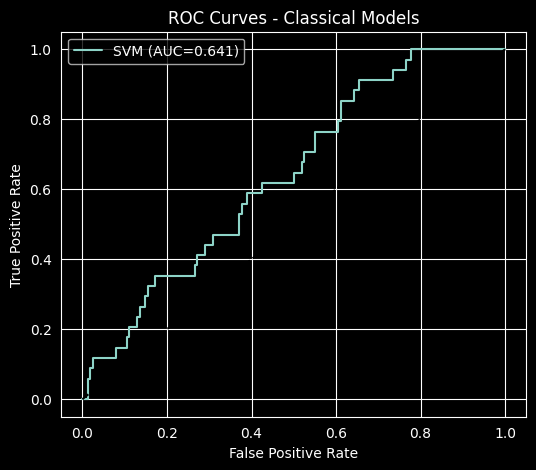

In [38]:
plt.figure(figsize=(6, 5))

y_prob = svm.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"SVM (AUC={roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Classical Models")
plt.legend()
plt.show()